In [1]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

2023-02-01 12:03:07.204578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 12:03:07.370381: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-01 12:03:07.411826: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-01 12:03:08.175886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = '0'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


2023-02-01 12:03:12.146181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 12:03:12.905031: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46703 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:98:00.0, compute capability: 8.6


In [3]:
if tf.config.list_physical_devices('GPU'):
  # Returns a dict in the form {'current': <current mem usage>,
  #                             'peak': <peak mem usage>}
    info = tf.config.experimental.get_memory_info('GPU:0')
print(info)

{'current': 0, 'peak': 0}


In [4]:
file_name ="Assignment4aDataset.txt"
fp = open(file_name,"r")
dates = []
for line in fp:
    dates.append(line)



In [5]:
symbs = ['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','-',' ','/','*','!','pad']
#    '*' is the start symbol and    '!'   is the end symbol   

i = 0
sym_dt = {}      #dictionary to look for token number
reverse_syms_dt = {}  #token number to charecter
for c in symbs:
    sym_dt[c] = i
    reverse_syms_dt[i] = c
    i += 1

print(len(sym_dt))
labs = list(sym_dt.values())
one_hots = tf.one_hot(labs,len(sym_dt))

42


In [6]:
max_pad = 30
dataset_x = []   #one hots for the input dates
dataset_y = []   #one hots for the output 
readable_sens = []  #actual dates
for i,x in enumerate(dates):
    xx = x.split(',')
    sen = []
    sen.append(one_hots[sym_dt['*']])
    
    readable_sens.append(xx[0][1:-1] +" : "+ xx[1][2:-2])
    for c in xx[0][1:-1]:
        sen.append(one_hots[sym_dt[c]])
        
    sen.append(one_hots[sym_dt['!']])
    padding = [one_hots[sym_dt["pad"]]]*(max_pad-len(sen))
    sen = sen+padding

    dataset_x.append(sen)

    date = []
    
    date.append(one_hots[sym_dt['*']])
    for c in xx[1][2:-2]:
        date.append(one_hots[sym_dt[c]])
        
    date.append(one_hots[sym_dt['!']])

    dataset_y.append(date)


    
dataset_x = np.array(dataset_x,dtype = 'float32')
dataset_y = np.array(dataset_y,dtype = 'float32')

In [13]:
print(readable_sens[0])

may 20 2034 : 2034-05-20


In [15]:
embeds = keras.layers.Embedding(len(sym_dt),64)  #embedding layer 
emb_data_x = []   # embeddings for input data instead of onehots
emb_data_y = []   # embeddings for output data 
for i,x in enumerate(dates):
    xx = x.split(',')
    sen = []
    sen.append(embeds(sym_dt['*']))
    
    for c in xx[0][1:-1]:
        sen.append(embeds(sym_dt[c]))
    sen.append(embeds(sym_dt['!']))
    padding = [embeds(sym_dt["pad"])]*(max_pad+3-len(sen))
    sen = sen+padding

    emb_data_x.append(sen)

    date = []
    date.append(one_hots[sym_dt['*']])
    for c in xx[1][2:-2]:
        date.append(one_hots[sym_dt[c]])
    date.append(one_hots[sym_dt['!']])

    emb_data_y.append(date)

emb_data_x = np.array(emb_data_x,dtype = 'float32')
emb_data_y = np.array(emb_data_y,dtype = 'float32')

print(emb_data_x.shape,emb_data_y.shape)


(40000, 33, 64) (40000, 12, 42)


In [39]:
class model_attention2(keras.Model):
    
    def __init__(self,out_dict_size,**kwargs):
        
        super(model_attention2,self).__init__(**kwargs)
        self.rnn_enc_cell = tf.keras.layers.LSTMCell(512,activation = "tanh",recurrent_dropout = 0.3) 
        self.rnn_enc = tf.keras.layers.RNN(self.rnn_enc_cell,return_sequences = True, return_state = True) 
        self.rnn_dec_cell = tf.keras.layers.LSTMCell(512,activation = "tanh",recurrent_dropout = 0.3)
        self.rnn_dec = tf.keras.layers.RNN(self.rnn_dec_cell,return_sequences = True) 
        self.mha = keras.layers.MultiHeadAttention(1,key_dim = 64)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
        self.out = tf.keras.layers.Dense(out_dict_size,activation = 'softmax')


    def call(self,inp,outp):

        seqs,state1,state2 = self.rnn_enc(inp) 
        
        x = self.rnn_dec(outp,initial_state = [state1,state1])
        att_vecs, self.att_vals = self.mha(x,seqs,return_attention_scores = True)
    
        pre_out = self.add([att_vecs,x])
        pre_out = self.layernorm(pre_out)

        probs = self.out(pre_out)

        return probs

    


In [ ]:
def train(inputs,targets,output_onehots,model):
    data_x = copy.deepcopy(inputs)
    data_y = copy.deepcopy(targets)
    one_hots = copy.deepcopy(output_onehots)
    tot_losses = []
    for x in range(epochs):
        ep_loss = 0
        index = 0
        while(index<40000):
            d = data_x[index:index+batch_size]
            y = data_y[index:index+batch_size]
            y_onehots = one_hots[index:index+batch_size]
            
            inds = np.arange(0,min(batch_size,len(d))) #shuffling inside batches
            np.random.shuffle(inds)
            d = d[inds]
            y = y[inds]
            y_onehots = y_onehots[inds]
            
            index += batch_size
            with tf.GradientTape() as tp:
                
                pred = model(d,y[:,:-1,:])   #end token is not fed into input i.e., end token is predicted
                ls = loss(y_onehots[:,1:,:],pred) #loss calculated from prediction without start symbol
                
            grads = tp.gradient(ls,model.trainable_weights) 
            optim.apply_gradients(zip(grads,model.trainable_weights))
            ep_loss += ls
            model.rnn_enc_cell.reset_recurrent_dropout_mask()
            model.rnn_dec_cell.reset_recurrent_dropout_mask()
        print("epoch : ", x, "loss : ", ep_loss/(len(data_x)/batch_size))
        tot_losses.append(ep_loss/(len(data_x)/batch_size))

    return tot_losses

In [102]:
optim = keras.optimizers.Adam()
loss = keras.losses.CategoricalCrossentropy()

epochs = 80

batch_size = 512

model = model_attention2(len(sym_dt))   

losses = train(dataset_x,dataset_y,dataset_y,model)  #model with onehots as inputs and target_sequences

epoch :  0 loss :  tf.Tensor(1.1821278, shape=(), dtype=float32)
epoch :  1 loss :  tf.Tensor(0.47055858, shape=(), dtype=float32)
epoch :  2 loss :  tf.Tensor(0.28239134, shape=(), dtype=float32)
epoch :  3 loss :  tf.Tensor(0.17856929, shape=(), dtype=float32)
epoch :  4 loss :  tf.Tensor(0.07443638, shape=(), dtype=float32)
epoch :  5 loss :  tf.Tensor(0.04575721, shape=(), dtype=float32)
epoch :  6 loss :  tf.Tensor(0.03443939, shape=(), dtype=float32)
epoch :  7 loss :  tf.Tensor(0.029624859, shape=(), dtype=float32)
epoch :  8 loss :  tf.Tensor(0.023567393, shape=(), dtype=float32)
epoch :  9 loss :  tf.Tensor(0.019162495, shape=(), dtype=float32)
epoch :  10 loss :  tf.Tensor(0.01667168, shape=(), dtype=float32)
epoch :  11 loss :  tf.Tensor(0.014066077, shape=(), dtype=float32)
epoch :  12 loss :  tf.Tensor(0.017910905, shape=(), dtype=float32)
epoch :  13 loss :  tf.Tensor(0.02025629, shape=(), dtype=float32)
epoch :  14 loss :  tf.Tensor(0.012614768, shape=(), dtype=float32)


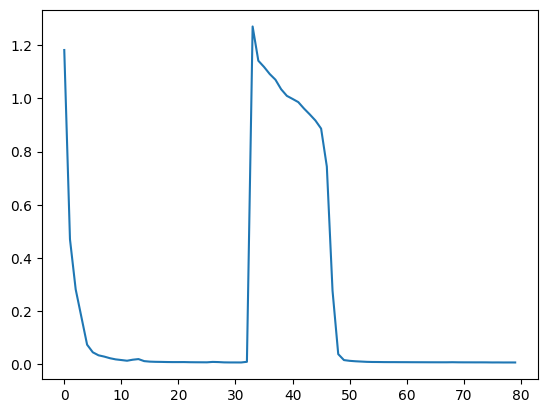

In [103]:
plt.plot(losses)

In [22]:
def gen_date(inp,model,target_dictionary,target_onehots,target_reverse_syms_dt):
    
    
    enc_seqs,state1,state2 = model.rnn_enc(inp)
    cnt = 0
    chr = '*'
    tot_scores = []
    
    cur_inp = tf.expand_dims(target_onehots[target_dictionary['*']],axis = 0)
    
    prev_state = state1
    res = []
    
    while(chr!='!'):

        if(cnt == 20):
            break
        cnt += 1
        out_dec = model.rnn_dec_cell(cur_inp,states = [prev_state,prev_state])
        
        att_vect,scores = model.mha(tf.expand_dims(out_dec[0],axis = 0),enc_seqs,return_attention_scores = True)
        pre_out = model.add([att_vect,out_dec[0]])
        pre_out = model.layernorm(pre_out,training = False)
        out = model.out(pre_out) 
    
        chr_ind = int(tf.argmax(out,axis = 2))
        chr = target_reverse_syms_dt[chr_ind]
        res.append(chr)
        tot_scores.append(np.squeeze(scores))
        
        prev_state = out_dec[0]
        cur_inp = tf.expand_dims(target_onehots[target_dictionary[chr]],axis = 0)

    return "".join(res),tot_scores


def plot_attention(att_scores,inp_sent_,out_sent_):
        
    inp_sent = []
    for c in inp_sent_:
        inp_sent.append(c)
    out_sent = []
    for c in out_sent_:
        out_sent.append(c)

    fig, ax = plt.subplots()
    im = ax.imshow(att_scores)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(inp_sent)), labels=inp_sent)
    ax.set_yticks(np.arange(len(out_sent)), labels=out_sent)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
#     for i in range(len(out_sent)):
#         for j in range(len(inp_sent)):
#             text = ax.text(j, i, att_scores[i][j],ha="center", va="center", color="w")

    ax.set_title("attention scores")
    fig.tight_layout()
    plt.show()

    
def one_hot_encode(sentence):
    out = []
    for c in sentence:
        out.append(one_hots[sym_dt[c]])
    return np.array(out)

def embed_sentence(sentence):
    out = []
    for c in sentence:
        out.append(embeds(sym_dt[c]))
    return np.array(out)
    


(12, 42)
1833-06-09!
(9, 12)


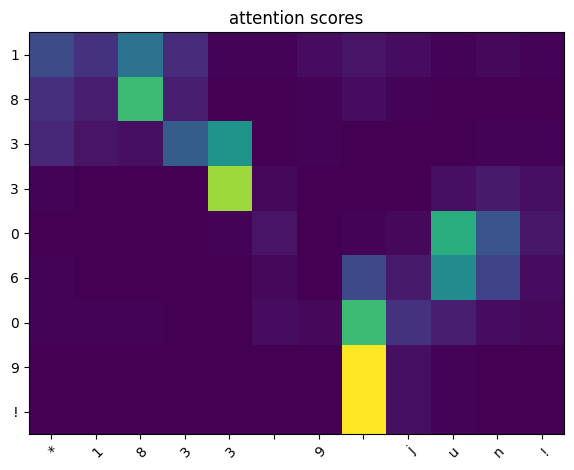

In [119]:


example = "*" + "1833 9 jun" + "!"

oh = one_hot_encode(example)
print(oh.shape)
output_date,scores = gen_date(np.expand_dims(oh,axis = 0),model,sym_dt,one_hots,reverse_syms_dt)
print(date)
print(np.array(scores).shape)
plot_attention(np.around(scores,2),example,output_date)

In [121]:
optim = keras.optimizers.Adam()
loss = keras.losses.CategoricalCrossentropy()

epochs = 50

batch_size = 512

model_2 = model_attention2(len(sym_dt))   

losses = train(emb_data_x,emb_data_y,dataset_y,model_2)  #model with embedded dates as inputs and target_sequences

epoch :  0 loss :  tf.Tensor(1.4701291, shape=(), dtype=float32)
epoch :  1 loss :  tf.Tensor(0.95995677, shape=(), dtype=float32)
epoch :  2 loss :  tf.Tensor(0.6427927, shape=(), dtype=float32)
epoch :  3 loss :  tf.Tensor(0.48122647, shape=(), dtype=float32)
epoch :  4 loss :  tf.Tensor(0.3890107, shape=(), dtype=float32)
epoch :  5 loss :  tf.Tensor(0.2908672, shape=(), dtype=float32)
epoch :  6 loss :  tf.Tensor(0.18603054, shape=(), dtype=float32)
epoch :  7 loss :  tf.Tensor(0.103500485, shape=(), dtype=float32)
epoch :  8 loss :  tf.Tensor(0.060425665, shape=(), dtype=float32)
epoch :  9 loss :  tf.Tensor(0.046260245, shape=(), dtype=float32)
epoch :  10 loss :  tf.Tensor(0.03622786, shape=(), dtype=float32)
epoch :  11 loss :  tf.Tensor(0.02881431, shape=(), dtype=float32)
epoch :  12 loss :  tf.Tensor(0.02479276, shape=(), dtype=float32)
epoch :  13 loss :  tf.Tensor(0.02182887, shape=(), dtype=float32)
epoch :  14 loss :  tf.Tensor(0.020583358, shape=(), dtype=float32)
epoch

In [132]:
epochs = 30
losses2 = train(emb_data_x,emb_data_y,dataset_y,model_2)

epoch :  0 loss :  tf.Tensor(0.9592432, shape=(), dtype=float32)
epoch :  1 loss :  tf.Tensor(0.95918995, shape=(), dtype=float32)
epoch :  2 loss :  tf.Tensor(0.95867294, shape=(), dtype=float32)
epoch :  3 loss :  tf.Tensor(0.9593777, shape=(), dtype=float32)
epoch :  4 loss :  tf.Tensor(0.9590122, shape=(), dtype=float32)
epoch :  5 loss :  tf.Tensor(0.9590258, shape=(), dtype=float32)
epoch :  6 loss :  tf.Tensor(0.958715, shape=(), dtype=float32)
epoch :  7 loss :  tf.Tensor(0.95849544, shape=(), dtype=float32)
epoch :  8 loss :  tf.Tensor(0.9583497, shape=(), dtype=float32)
epoch :  9 loss :  tf.Tensor(0.9581662, shape=(), dtype=float32)
epoch :  10 loss :  tf.Tensor(0.9579298, shape=(), dtype=float32)
epoch :  11 loss :  tf.Tensor(0.9575913, shape=(), dtype=float32)
epoch :  12 loss :  tf.Tensor(0.9562997, shape=(), dtype=float32)
epoch :  13 loss :  tf.Tensor(0.9561615, shape=(), dtype=float32)
epoch :  14 loss :  tf.Tensor(0.95067257, shape=(), dtype=float32)
epoch :  15 loss 

In [154]:
epochs = 15
losses2 = train(emb_data_x,emb_data_y,dataset_y,model_2)

epoch :  0 loss :  tf.Tensor(0.014327642, shape=(), dtype=float32)
epoch :  1 loss :  tf.Tensor(0.014056466, shape=(), dtype=float32)
epoch :  2 loss :  tf.Tensor(0.013563593, shape=(), dtype=float32)
epoch :  3 loss :  tf.Tensor(0.012444224, shape=(), dtype=float32)
epoch :  4 loss :  tf.Tensor(0.011801146, shape=(), dtype=float32)
epoch :  5 loss :  tf.Tensor(0.014128749, shape=(), dtype=float32)
epoch :  6 loss :  tf.Tensor(0.011509024, shape=(), dtype=float32)
epoch :  7 loss :  tf.Tensor(0.010960865, shape=(), dtype=float32)
epoch :  8 loss :  tf.Tensor(0.010655553, shape=(), dtype=float32)
epoch :  9 loss :  tf.Tensor(0.010965284, shape=(), dtype=float32)
epoch :  10 loss :  tf.Tensor(0.009713366, shape=(), dtype=float32)
epoch :  11 loss :  tf.Tensor(0.009241699, shape=(), dtype=float32)
epoch :  12 loss :  tf.Tensor(0.0094693275, shape=(), dtype=float32)
epoch :  13 loss :  tf.Tensor(0.20855786, shape=(), dtype=float32)
epoch :  14 loss :  tf.Tensor(0.035025083, shape=(), dtype

(40000, 12, 13)

In [ ]:
#########   TRANFORMER   ####################

In [7]:
def positional_encoding(length = 2048, depth = 512):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)],axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x
    
    

In [8]:
tokens_x = []
tokens_y = []
readable_sens = []
for i,x in enumerate(dates):
    xx = x.split(',')
    sen = []
    sen.append(sym_dt['*'])
    
    readable_sens.append(xx[0][1:-1] +" : "+ xx[1][2:-2])
    for c in xx[0][1:-1]:
        sen.append(sym_dt[c])
        
    sen.append(sym_dt['!'])
    padding = [sym_dt["pad"]]*(max_pad-len(sen))
    sen = sen+padding

    tokens_x.append(sen)

    date = []
    
    date.append(sym_dt['*'])
    for c in xx[1][2:-2]:
        date.append(sym_dt[c])
        
    date.append(sym_dt['!'])

    tokens_y.append(date)

tokens_x = np.array(tokens_x)
tokens_y = np.array(tokens_y)


In [10]:
print(tokens_x.shape,tokens_y.shape)

(40000, 30) (40000, 12)


In [52]:
emb_dimension = 128
pos = PositionalEmbedding(len(sym_dt),emb_dimension)

#caching the positional embeddings 

posenc_x = pos(tokens_x)
posenc_y = pos(tokens_y)
print(posenc_x.shape,posenc_y.shape)

posenc_x2 = posenc_x.numpy()
posenc_y2 = posenc_y.numpy()

(40000, 30, 128) (40000, 12, 128)


In [56]:
class create_encoder_block(keras.Model):
    def __init__(self,dns,activ,**kwargs):
        super(create_encoder_block,self).__init__(**kwargs)
        self.attention_self = keras.layers.MultiHeadAttention(1,dns)
        self.norm1 = keras.layers.LayerNormalization()
        self.add = keras.layers.Add()
        self.dense = keras.layers.Dense(dns,activation = activ)
        self.norm2 = keras.layers.LayerNormalization()
        self.dropout = keras.layers.Dropout(0.3)
        
    def call(self,inp):
        
        self_att_vecs,self_att_scores = self.attention_self(inp,inp,return_attention_scores = True)
        
        residual_vals1 = self.add([inp,self_att_vecs])
        
        normalized_resids1 = self.norm1(residual_vals1)
        
        resids_drop = self.dropout(normalized_resids1)
        
        dense_outs = self.dense(resids_drop)
        
        residual_vals2 = self.add([dense_outs,normalized_resids1])
        
        normalized_resids2 = self.norm2(residual_vals2)
        
        return normalized_resids2
    
class create_decoder_block(keras.Model):
    def __init__(self,dns,activ,**kwargs):
        super(create_decoder_block,self).__init__(**kwargs)
        self.attention_self = keras.layers.MultiHeadAttention(1,dns)
        self.attention_cross = keras.layers.MultiHeadAttention(1,dns)
        self.add = keras.layers.Add()
        self.dense = keras.layers.Dense(dns,activation = activ)
        self.dropout = keras.layers.Dropout(0.3)
        self.norm1 = keras.layers.LayerNormalization()
        self.norm2 = keras.layers.LayerNormalization()
        self.norm3 = keras.layers.LayerNormalization()
        
    def call(self,dec_inp,enc_out):
        
        self_att_vecs,self_att_scores = self.attention_self(dec_inp,dec_inp,use_causal_mask = True,return_attention_scores = True)
        
        resids_self = self.add([self_att_vecs,dec_inp])
        
        normalized_self = self.norm1(resids_self)
        
        cross_att_vecs,cross_att_scores = self.attention_cross(normalized_self,enc_out,return_attention_scores = True)
        
        self.visualization = cross_att_scores[-1]
        
        resids_cross = self.add([cross_att_vecs,normalized_self])
        
        normalized_cross = self.norm2(resids_cross)
        
        normalized_cross_drop = self.dropout(normalized_cross)
        
        feed_forward = self.dense(normalized_cross_drop)
        
        resids_3 = self.add([normalized_cross,feed_forward])
        
        normalized_3 = self.norm3(resids_3)
        
        
        return normalized_3
    
    

In [11]:
posenc_x2[:1].shape

(1, 30, 64)

In [12]:
class create_encoder_stack(keras.Model):
    def __init__(self,dns,activ,enc_stk_len,**kwargs):
        super(create_encoder_stack,self).__init__()
        self.enc_stk = []
        for i in range(enc_stk_len):
            self.enc_stk.append(create_encoder_block(dns,activ))
            
    def call(self,inp):
        x = inp
        for enc_block in self.enc_stk:
            x = enc_block(x)
            
        return x
            
class create_decoder_stack(keras.Model):
    def __init__(self,dns,activ,enc_stk_len,**kwargs):
        super(create_decoder_stack,self).__init__()
        self.dec_stk = []
        for i in range(enc_stk_len):
            self.dec_stk.append(create_decoder_block(dns,activ))
            
    def call(self,dec_inp,enc_out):
        x = dec_inp
        for dec_block in self.dec_stk:
            x = dec_block(x,enc_out)
            
        self.att_scores =  self.dec_stk[0].visualization
            
        return x
            

In [57]:
class transformer(keras.Model):
    def __init__(self,dns,activ,enc_stk_len,dec_stk_len,**kwargs):
        super(transformer,self).__init__(**kwargs)
        
        
        self.enc_stk = create_encoder_stack(dns,activ,enc_stk_len)
        self.dec_stk = create_decoder_stack(dns,activ,dec_stk_len)
        
            
        self.softmax = keras.layers.Dense(len(sym_dt),activation = "softmax")
  
    def call(self,inp,out):

        enc_out = self.enc_stk(inp)

        dec_out = self.dec_stk(out,enc_out)
        
        out = self.softmax(dec_out)
        

        return out
        
        
        
        
        
        

In [58]:


def train_transformer(pos_xx,pos_yy,yy,model):
    emb_x = copy.deepcopy(pos_xx)        #position enocded vectors of input dates
    emb_y = copy.deepcopy(pos_yy)        #position encoded vectors of target dates
    ohv_y = copy.deepcopy(yy)            #onehot vectors for target dates
    tot_losses = []
    for x in range(epochs):
        ep_loss = 0
        index = 0
        while(index<40000):
            d = emb_x[index:index+batch_size]
            y = emb_y[index:index+batch_size]
            loss_y = ohv_y[index:index+batch_size]
            inds = np.arange(0,min(batch_size,len(d)))
            np.random.shuffle(inds)
            d = d[inds]
            y = y[inds]
            loss_y = loss_y[inds]
            index += batch_size
            with tf.GradientTape() as tp:
                pred = model(d,y[:,:-1,:])
                ls = loss(loss_y[:,1:,:],pred)
            grads = tp.gradient(ls,model.trainable_weights) 
            optim.apply_gradients(zip(grads,model.trainable_weights))
            ep_loss += ls
        print("epoch : ", x, "loss : ", ep_loss/(len(emb_x)/batch_size))
        tot_losses.append(ep_loss/(len(emb_x)/batch_size))
    return tot_losses

In [61]:
epochs = 6
batch_size = 256

optim = keras.optimizers.Adam()
loss = keras.losses.CategoricalCrossentropy()

trans_model = transformer(emb_dimension,"tanh",6,6)

losses = train_transformer(posenc_x2,posenc_y2,dataset_y,trans_model)


epoch :  0 loss :  tf.Tensor(1.1001443, shape=(), dtype=float32)
epoch :  1 loss :  tf.Tensor(0.08606955, shape=(), dtype=float32)
epoch :  2 loss :  tf.Tensor(0.08440404, shape=(), dtype=float32)
epoch :  3 loss :  tf.Tensor(0.013440118, shape=(), dtype=float32)
epoch :  4 loss :  tf.Tensor(0.011827845, shape=(), dtype=float32)
epoch :  5 loss :  tf.Tensor(0.010109114, shape=(), dtype=float32)


In [70]:
def get_date_trans(inp,model):
            
        
        tokens = [sym_dt["*"]]

        nex_pos_enc = pos(np.expand_dims(np.array(tokens),axis = 0))
        
        enc_out = model.enc_stk(inp,training = False)
        
        ch = '*'
        cnt = 0
        t_att_scores11 = []
        t_att_scores21 = []
        t_att_scores31 = []
        
        t_att_scores12,t_att_scores22,t_att_scores32 = [],[],[]
        
        ans = [ch]
        
        result_scores = []
        while(ch != "!"):
            
            if(cnt == 15):
                break
            cnt += 1
            
            dec_out = model.dec_stk(nex_pos_enc,enc_out,training = False)
            
            result_scores.append(model.dec_stk.dec_stk[1].visualization[0][-1])
#             print(model.dec_stk.dec_stk[1].visualization[0][-1].shape)

            out = model.softmax(dec_out) 
            
            ind = tf.argmax(out[:,-1:,:],axis = 2)
            ch = reverse_syms_dt[int(ind)]
            ans.append(ch)
            tokens.append(ind[0][0])
            
            
            nex_pos_enc = pos(np.expand_dims(np.array(tokens),axis = 0))
   
        
        return "".join(ans[1:]),result_scores,[t_att_scores11,t_att_scores21,t_att_scores31], [t_att_scores12,t_att_scores22,t_att_scores32]
        
x = 19099

print(dates[x])
output_date,cross_scores,result_scores,self_scores = get_date_trans(posenc_x[x:x+1],trans_model)  
print(output_date)

'saturday october 30 1813', '1813-10-30'

1813-10-30!


1931-12-22!


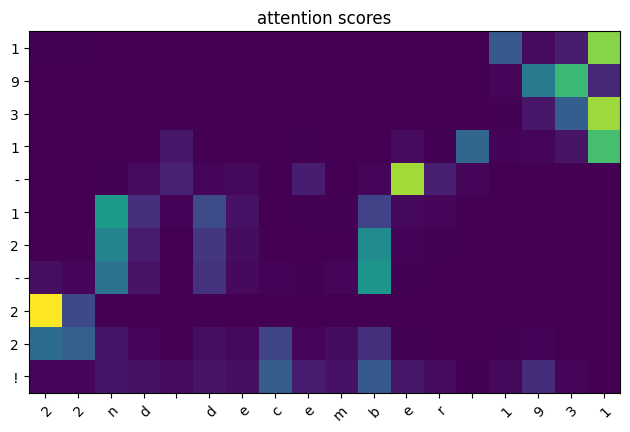

In [93]:

def tokenize(sent):
    
    out = []
    for i in sent:
        out.append(sym_dt[i])
    return np.array(out)

example = '22nd december 1931'
tokenized = tokenize(example)
pos_encoded = pos(np.expand_dims(tokenized,axis =0))

output_date,att_scores,cross_att_scores,self_att_scores = get_date_trans(pos_encoded,trans_model)

    
print(output_date)
# print(np.array(scores).shape)
plot_attention(att_scores,example,output_date)




#plot is attention scores of 1st decoder layer on encoder sequence